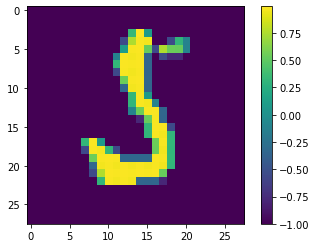

In [1]:
import mnist
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as skld

TRAIN = mnist.train_images()
def sample_mnist(N):
    idx = np.random.choice(np.arange(len(TRAIN)), N)
    return 2*(torch.FloatTensor(TRAIN[idx]/256)-0.5)

plt.imshow(sample_mnist(10)[0])
plt.colorbar()

In [2]:
data_dim = 28*28
noise_dim = 128

make_gener = lambda N = 100: torch.nn.Sequential(
    torch.nn.Linear(noise_dim,N),
    torch.nn.ReLU(),
    torch.nn.Linear(N,N),
    torch.nn.ReLU(),
    torch.nn.Linear(N,data_dim),
    torch.nn.Tanh(),
    torch.nn.Unflatten(-1,(28,28))
)
make_discr = lambda: torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(data_dim,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,1),
    torch.nn.Sigmoid()
)

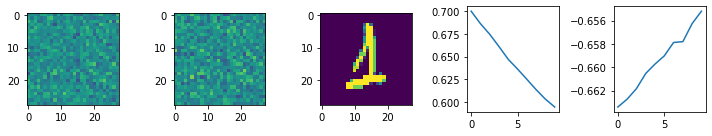

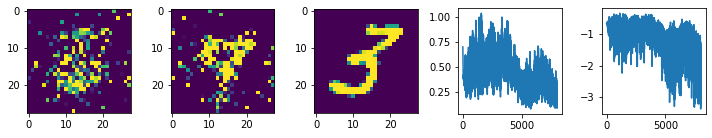

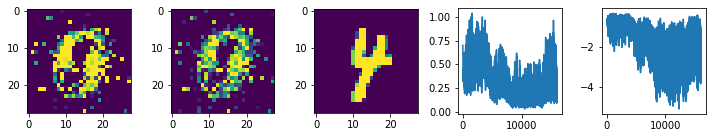

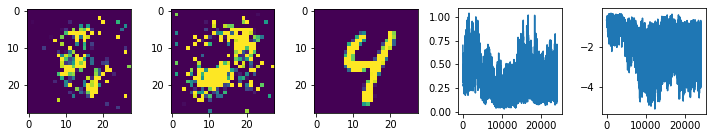

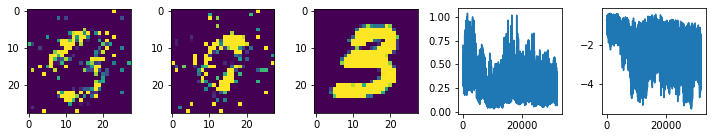

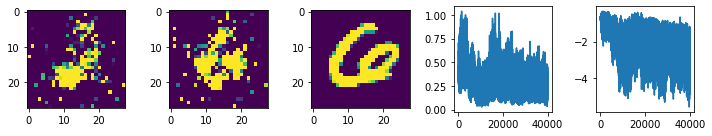

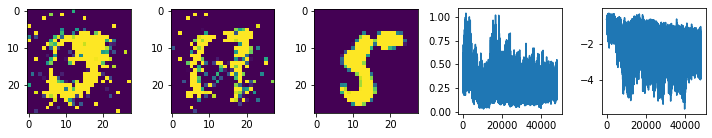

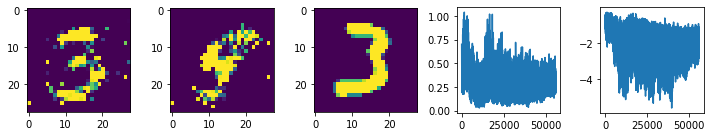

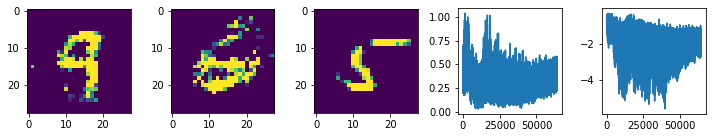

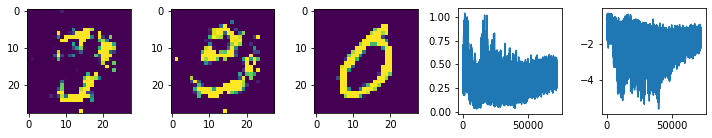

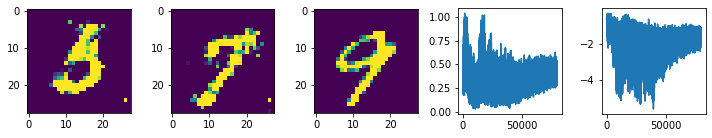

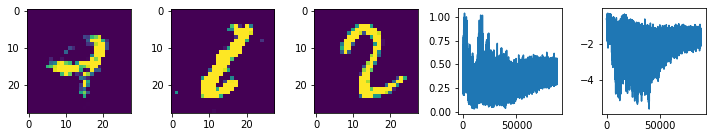

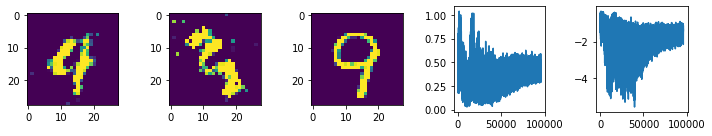

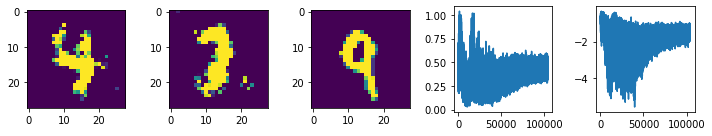

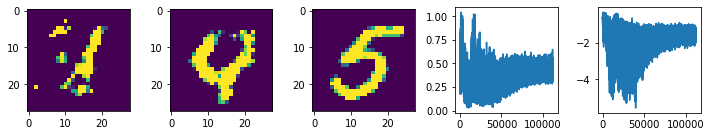

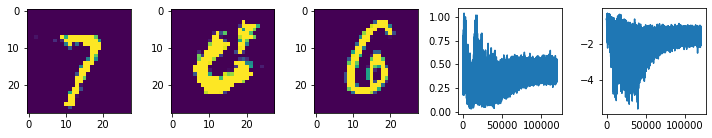

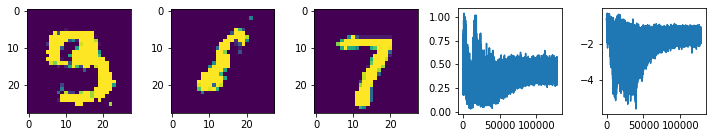

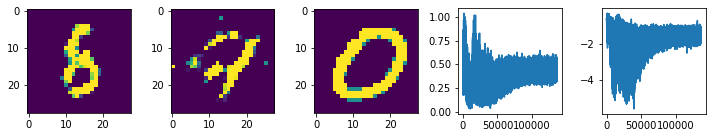

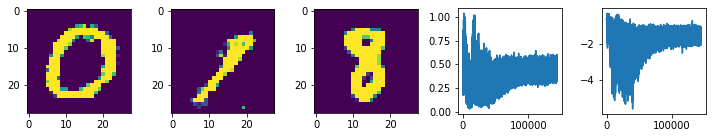

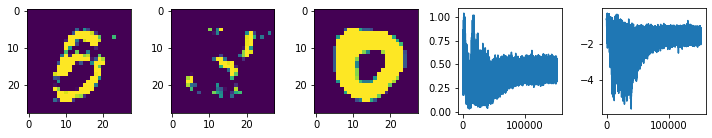

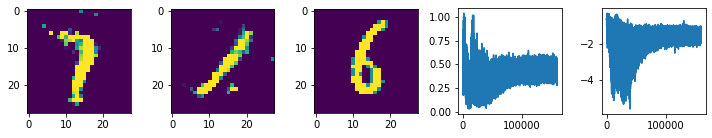

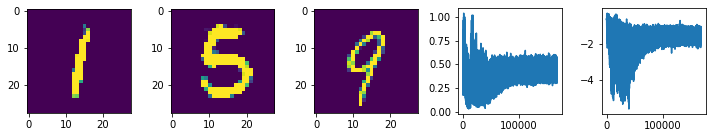

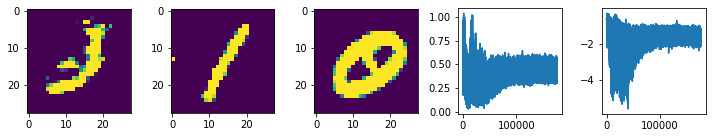

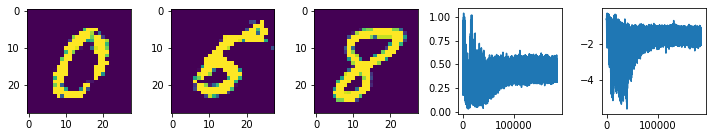

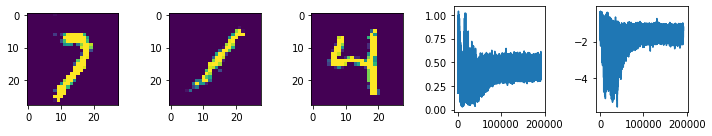

In [4]:
def run_gan_d(Nreal,Nfake,discr,gener):
    real = sample_mnist(Nreal)
    fake = gener(torch.randn(Nfake,noise_dim))
    loss = -(torch.log(discr(real)).mean() + torch.log(1-discr(fake)).mean())
    loss =  loss/2.
    return loss

def run_gan_g(Nfake,discr,gener):
    Nreal = Nfake
    real = sample_mnist(Nreal)
    fake = gener(torch.randn(Nfake,noise_dim))
#     loss = torch.log(1-discr(fake)).mean()
#     return loss/2.
    loss = -torch.log(discr(fake)).mean()
    return loss

def train_discr(Nbatch, opt_d, opt_g, traj,discr,gener,N):
    for j in range(N):
        loss = run_gan_d(Nreal=Nbatch,Nfake=Nbatch,  discr = discr, gener = gener)
        traj.append(float(loss))
        loss.backward()
        opt_d.step()
        opt_d.zero_grad()
        opt_g.zero_grad()

def train_gener(Nbatch, opt_d, opt_g, traj,discr,gener,N):
    for j in range(N):
        loss = run_gan_g(Nfake=Nbatch,  discr = discr, gener = gener)
        traj.append(float(loss))
        loss.backward()
        opt_g.step()
        opt_d.zero_grad()
        opt_g.zero_grad()
    
            
def train():
    discr = make_discr()
    gener = make_gener()
    opt_d = torch.optim.Adam(discr.parameters(), 1e-4)
    opt_g = torch.optim.Adam(gener.parameters(), 1e-4)

    traj_d = []
    traj_g = []
    Nbatch = 100

    for i in range(100*200):
        train_gener(Nbatch, opt_d, opt_g, traj_g,discr,gener,10)
        train_discr(Nbatch, opt_d, opt_g, traj_d,discr,gener,10)
        if i % 800 == 0:
            gener.eval()
            discr.eval()
            f,axarr = plt.subplots(1,5)
            with torch.no_grad():
                generations = gener(torch.randn(500,noise_dim)).detach()
            reals = sample_mnist(500)
            axarr[0].imshow(generations[0], vmin = -0.5, vmax = 0.5)
            axarr[1].imshow(generations[1], vmin = -0.5, vmax = 0.5)
            axarr[2].imshow(reals[0], vmin = -0.5, vmax = 0.5)
            axarr[3].plot(np.array(traj_d))
            axarr[4].plot(-np.array(traj_g))
            plt.gcf().set_size_inches(10,2)
            f.set_tight_layout(True)
            plt.show()
    return gener

model = train()

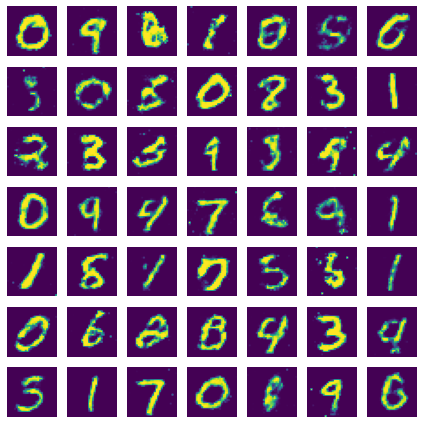

In [5]:
f,axarr = plt.subplots(7,7)
with torch.no_grad():
    generations = model(torch.randn(len(axarr.ravel()),noise_dim)).detach()
for ax,gen in zip(axarr.ravel(),generations):
    ax.imshow(gen)
    ax.axis('off')
f.set_tight_layout(True)
f.set_size_inches(6,6)